<a href="https://colab.research.google.com/github/JakeOh/202505_BD50/blob/main/lab_da/ml17_ann_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST 이미지 분류

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [2]:
tf.__version__

'2.19.0'

In [3]:
keras.__version__

'3.10.0'

In [4]:
print(keras.config.backend())  # Keras 라이브러리에서 신경망 계산을 할 때 필요한 라이브러리.

tensorflow


In [5]:
print(tf.config.list_physical_devices())  # CPU/GPU/TPU 사용 여부 확인

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Keras 라이브러리는 GPU 연산을 직접 수행하지 않음. 대신에 GPU 연산을 수행하는 다른 딥러닝 라이브러리를 백엔드(backend)로 활용함.

*   Keras에서 사용할 수 있는 백엔드 종류
    *   TensorFlow - Google에서 만든 텐서(Tensor) 연산을 빠르게 수행하기 위한 라이브러리.
    *   PyTorch - Meta(페이스북)에서 만든 딥러닝 라이브러리 -> 리눅스 재단으로 오픈소스로 공개.
*   Keras
    *   여러가지 백엔드를 사용해서 신경망을 쉽게 만들고 사용할 수 있도록 만든 고급 라이브러리.
    *   2.3.1 버전 이후부터는 TensorFlow만 단일 백엔드로 사용하도록 기능 변경.
    *   3.0 버전부터 다시 멀티 백엔드 정책으로 바뀜.

# Fashion MNIST 데이터 셋

10가지 패션 아이템의 28x28 크기의 흑백 이미지 60,000개 훈련 셋/레이블, 10,000개 테스트 셋/레이블.

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# (훈련 셋, 훈련 레이블), (테스트 셋, 테스트 레이블)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
x_train.shape  # (n_samples, image_width, image_height)

(60000, 28, 28)

In [8]:
y_train.shape

(60000,)

In [9]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [10]:
x_test.shape

(10000, 28, 28)

In [11]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

훈련셋, 테스트셋 모두 각 클래스의 샘플들이 동일한 개수로 만들어져 있음.

데이터셋의 이미지를 시각화해 보세요.

In [12]:
def plot_fashion_mnist(arr, ncols=10):
    # arr: (samples, width, height) shape의 3차원 배열
    # ncols: subplot axis의 컬럼 개수.
    n = len(arr)  # 출력할 이미지 개수
    nrows = int(np.ceil(n / ncols))  # subplot Axis 행 개수.
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j  # arr에서 선택할 이미지 인덱스.
            if nrows == 1 or ncols == 1:  # ax가 1차원 배열인 경우
                if idx < n:
                    ax[idx].imshow(arr[idx], cmap=plt.cm.binary)
                ax[idx].axis('off')
            else:  # ax가 2차원 배열인 경우
                if idx < n:
                    ax[i, j].imshow(arr[idx], cmap=plt.cm.binary)
                ax[i, j].axis('off')
    plt.show()

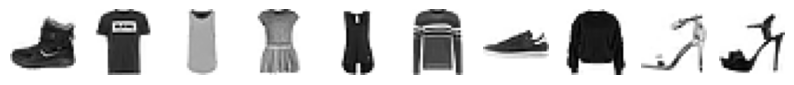

In [13]:
plot_fashion_mnist(x_train[:10])

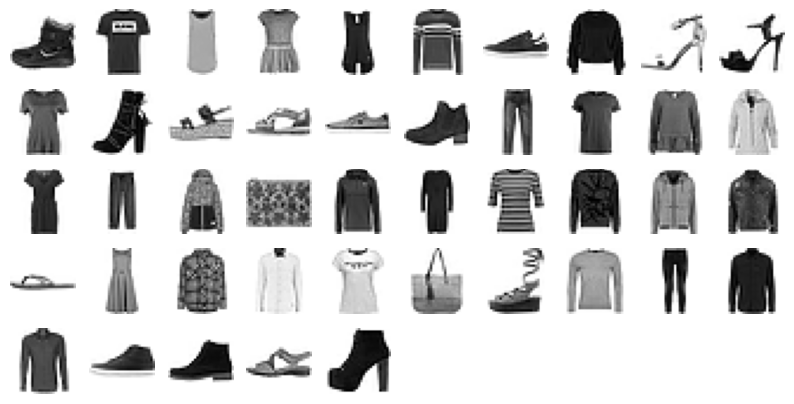

In [14]:
plot_fashion_mnist(x_train[:45])

# 훈련 셋/레이블을 훈련 셋과 검증 셋으로 분리

In [15]:
train_data, val_data, train_target, val_target = \
        train_test_split(x_train, y_train, random_state=42, test_size=0.2, stratify=y_train)

In [16]:
print(train_data.shape)
print(train_target.shape)
print(np.unique(train_target, return_counts=True))

(48000, 28, 28)
(48000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800]))


In [17]:
print(val_data.shape)
print(val_target.shape)
print(np.unique(val_target, return_counts=True))

(12000, 28, 28)
(12000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]))


# SGD Classifier

In [18]:
train_data[0]  #> 각 픽셀의 값들이 0(white) ~ 255(white)

array([[  0,   0,   0,   0,   1,   1,   0,   0,   0,  25,  55,   0,   0,
          0,   0,   0,   0,  43,  24,   0,   0,   0,   1,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   1,   1,   0,  25, 147, 189, 181,  96,  51,
         49,  55,  37,  76, 217, 172, 125,  20,   0,   2,   1,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   3,   0,  82, 206, 202, 190, 178, 188, 239,
        152,  99, 199, 201, 162, 176, 192, 185,  71,   0,   2,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0, 202, 196, 181, 188, 183, 169, 179,
        160, 107, 198, 166, 167, 178, 170, 183, 166,   0,   0,   1,   0,
          0,   0],
       [  0,   0,   0,   1,   0,  48, 216, 184, 185, 185, 190, 175, 164,
        188, 198, 188, 157, 183, 176, 171, 167, 175,  26,   0,   2,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  90, 224, 183, 185, 184, 183, 190, 164,
        169, 193, 158, 170, 174, 176, 175, 165, 180,  62,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 123, 228, 184, 180, 183, 178, 183, 172,
        172, 172, 161, 179, 170, 174, 175, 165, 181, 106,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 156, 229, 188, 175, 178, 175, 175, 190,
        157, 157, 180, 169, 169, 172, 171, 161, 179, 143,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 181, 228, 190, 174, 174, 176, 175, 197,
        167, 167, 183, 166, 169, 171, 170, 162, 175, 172,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   6, 175, 221, 192, 170, 174, 176, 175, 193,
        176, 172, 175, 167, 169, 169, 167, 160, 169, 196,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  23, 184, 216, 206, 164, 175, 176, 175, 192,
        178, 175, 174, 167, 166, 169, 169, 165, 169, 175,   6,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  53, 189, 208, 219, 161, 176, 176, 175, 190,
        181, 178, 172, 169, 165, 170, 169, 166, 167, 183,  26,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  84, 194, 207, 216, 157, 176, 175, 176, 193,
        183, 180, 172, 167, 167, 166, 170, 165, 167, 185,  61,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 114, 193, 211, 207, 157, 175, 175, 176, 196,
        183, 181, 172, 166, 166, 165, 170, 164, 169, 187,  88,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 155, 192, 219, 194, 161, 172, 178, 176, 197,
        185, 181, 169, 166, 165, 165, 171, 164, 171, 184, 108,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 181, 192, 225, 185, 162, 172, 179, 176, 199,
        185, 183, 169, 166, 164, 164, 172, 161, 170, 184, 135,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 210, 189, 233, 180, 161, 171, 179, 179, 201,
        185, 190, 166, 166, 164, 164, 176, 158, 171, 183, 155,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 229, 184, 234, 176, 164, 169, 180, 183, 198,
        185, 193, 166, 167, 164, 165, 179, 157, 176, 179, 174,   0,   0,
          0,   0],
       [  0,   0,   0,   2, 237, 183, 237, 171, 166, 167, 178, 188, 196,
        187, 196, 164, 166, 165, 166, 179, 157, 178, 176, 185,   2,   0,
          0,   0],
       [  0,   0,   0,  24, 246, 184, 255, 172, 166, 169, 180, 192, 196,
        189, 201, 161, 164, 165, 165, 181, 161, 181, 176, 189,  17,   0,
          0,   0],
       [  0,   0,   0,  52, 247, 187, 238, 166, 170, 170, 180, 198, 193,
        189, 207, 160, 165, 165, 164, 180, 162, 187, 175, 192,  52,   0,
          0,   0],
       [  0,   0,   0,  82, 215, 192, 239, 158, 169, 174, 179, 207, 189,
        187, 213, 160, 167, 166, 165, 181, 169, 190, 170, 192,  73,   0,
          0,   0],
       [  0,   0,   0, 102, 212, 201, 212, 166, 169, 171, 179, 217, 189,
        187, 217, 157, 170, 167, 166, 178, 171, 196, 169, 171,  84,   0,
          0,   0],
       [  0,   0,   0, 166, 211, 213, 193, 164, 170, 170, 180, 226, 181,
        187, 228, 157, 167, 167, 158, 188, 196, 128, 170, 179, 128,   0,
          0,   0],
       [  0,   0,   0,  35,  92, 129, 19

In [19]:
# 훈련 셋의 픽셀 값을 0 ~ 1 사이의 값으로 스케일링 -> 확률적 경사 하강법 성능을 높이기 위해서.
train_data_scaled = train_data / 255.0

In [20]:
train_data_scaled[0]

array([[0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.00392157, 0.        , 0.        , 0.        , 0.09803922,
        0.21568627, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.16862745, 0.09411765, 0.        ,
        0.        , 0.        , 0.00392157, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00392157, 0.00392157,
        0.00392157, 0.        , 0.09803922, 0.57647059, 0.74117647,
        0.70980392, 0.37647059, 0.2       , 0.19215686, 0.21568627,
        0.14509804, 0.29803922, 0.85098039, 0.6745098 , 0.49019608,
        0.07843137, 0.        , 0.00784314, 0.00392157, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00392157, 0.01176471,
        0.        , 0.32156863, 0.80784314, 0.79215686, 0.74509804,
        0.69803922, 0.7372549 , 0.9372549 , 0.59607843, 0.38823529,
        0.78039216, 0.7882

In [21]:
sgd = SGDClassifier(loss='log_loss', random_state=42, n_jobs=-1)

In [22]:
sgd.fit(X=train_data_scaled.reshape((48_000, -1)), y=train_target)

SGDClassifier(loss='log_loss', n_jobs=-1, random_state=42)

In [23]:
sgd.intercept_  #> shape: (10,)

array([ -1.54024535,  -4.97085256,  -2.45411884,  -1.5496291 ,
        -4.94592029,   3.66151889,  -1.47955462,  -1.90241534,
        -4.40078057, -25.19876253])

In [24]:
sgd.coef_.shape  #> (10, 784)

(10, 784)

In [25]:
predict_probas = sgd.predict_proba(X=train_data_scaled.reshape((48_000, -1)))

In [26]:
predict_probas.shape  #> (48_000, 10)

(48000, 10)

In [27]:
predict_probas[:5]

array([[1.20888251e-02, 1.05549631e-05, 2.30094285e-01, 3.41231387e-03,
        4.86284532e-02, 3.96063160e-10, 6.91742929e-01, 1.54454383e-17,
        1.40226378e-02, 1.05805064e-16],
       [7.53889861e-01, 1.20438290e-04, 4.89841116e-05, 2.88644150e-04,
        7.52168267e-02, 4.15812599e-17, 1.69806662e-01, 2.22627871e-15,
        6.28584469e-04, 3.41774283e-15],
       [2.89450403e-03, 2.51542365e-04, 1.32250305e-04, 9.78121334e-01,
        2.43557068e-04, 8.15414752e-12, 1.83430550e-02, 1.32044303e-06,
        1.24368179e-05, 1.15226778e-10],
       [1.87927047e-02, 1.53865511e-02, 4.75084700e-03, 9.59873842e-01,
        2.15421676e-04, 2.30937550e-07, 4.85837345e-04, 7.79498173e-08,
        4.94463323e-04, 2.39574997e-08],
       [9.71611164e-01, 8.55700455e-07, 2.35430174e-03, 2.77866962e-07,
        7.27359445e-06, 2.50343665e-19, 2.58251753e-02, 6.13245802e-16,
        2.00951140e-04, 2.02813751e-10]])

In [28]:
predicts = sgd.predict(X=train_data_scaled.reshape((48_000, -1)))

In [29]:
predicts.shape  #> (48_000,)

(48000,)

In [30]:
predicts[:5]

array([6, 0, 3, 3, 0], dtype=uint8)

In [31]:
accuracy_score(train_target, predicts)  # 훈련 셋 정확도

0.8518125

In [32]:
# 검증 셋의 모든 픽셀을 0 ~ 1 사이로 스케일링
val_data_scaled = val_data / 255.0
# 검증 셋의 예측값
val_predicts = sgd.predict(X=val_data_scaled.reshape((12_000, -1)))
# 검증 셋의 정확도
accuracy_score(y_true=val_target, y_pred=val_predicts)

0.8468333333333333

# 신경망

Keras 라이브러리를 사용해서 입력층과 출력층만 갖는 신경망을 만들고 테스트하세요.

In [33]:
tr_data_scaled_flat = train_data_scaled.reshape((48_000, -1))  #> shape: (48_000, 784)
val_data_scaled_flat = val_data_scaled.reshape((12_000, -1))   #> shape: (12_000, 784)

In [34]:
print(tr_data_scaled_flat.shape)
print(val_data_scaled_flat.shape)

(48000, 784)
(12000, 784)


In [35]:
inputs = keras.layers.Input(shape=(784,))  # 입력층

In [36]:
dense = keras.layers.Dense(units=10, activation='softmax')  # 출력층

In [37]:
model = keras.Sequential(layers=[inputs, dense])  # 완전 연결 신경망

In [38]:
model.summary()
#> 모델 파라미터 개수 = (784 weight * 10 output) + 10 bias =  7,850

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [40]:
model.fit(x=tr_data_scaled_flat, y=train_target, epochs=5, verbose=0)

In [41]:
predicts = model.predict(x=tr_data_scaled_flat)
#> 48,000개 이미지의 각 레이블이 될 확률을 리턴.

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [42]:
predicts.shape  #> (48_000 이미지 샘플, 10개 확률)

(48000, 10)

In [43]:
print(predicts[:2])

[[6.7939325e-03 5.3360700e-06 2.5981352e-01 6.3672676e-03 1.8436359e-02
  2.5645908e-13 7.0217389e-01 4.9357710e-18 6.4097210e-03 4.6465399e-17]
 [7.1363914e-01 6.1809862e-07 1.9443699e-03 2.7853143e-03 2.5896060e-03
  7.2812355e-21 2.7857181e-01 1.9749328e-18 4.6918521e-04 2.5880310e-18]]


In [44]:
tr_pred_labels = predicts.argmax(axis=1)
# argmax(): 최댓값의 인덱스를 리턴. 10개의 확률들 중 최댓값의 인덱스가 예측 레이블이 됨.

In [45]:
tr_pred_labels.shape

(48000,)

In [46]:
tr_pred_labels[:2]

array([6, 0])

In [47]:
accuracy_score(y_true=train_target, y_pred=tr_pred_labels)

0.8564375

In [48]:
# 훈련 셋 평가 - model의 evaluate 메서드를 사용할 수도 있음.
model.evaluate(x=tr_data_scaled_flat, y=train_target, verbose=0)
#> [loss(손실), accuracy(정확도)]

[0.4285393953323364, 0.8564375042915344]

In [49]:
# 검증 셋 평가
model.evaluate(x=val_data_scaled_flat, y=val_target, verbose=0)

[0.42980581521987915, 0.8538333177566528]

# 활성화 함수(Activation Function)

## Sigmoid

$
\text{sigmoid}(x) = \dfrac{1}{1 + \exp(-x)}
$

In [50]:
xvals = np.arange(-5, 5, 0.0001)

In [51]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [53]:
yvals = sigmoid(xvals)

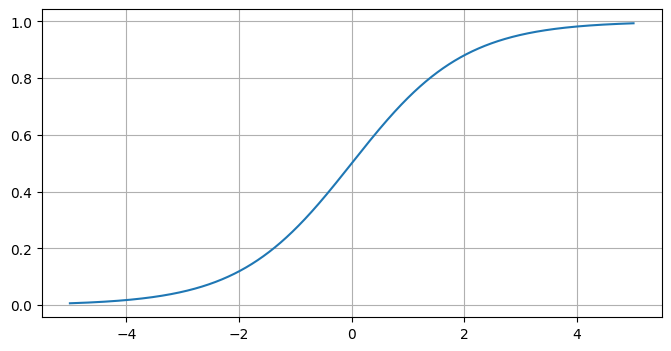

In [54]:
plt.figure(figsize=(8, 4))
plt.plot(xvals, yvals)
plt.grid()
plt.show()

## Hyperbolic tangent

In [56]:
def plot_activation_fn(fn):
    xvals = np.arange(-5, 5, 0.0001)
    yvals = fn(xvals)
    plt.figure(figsize=(8, 4))
    plt.plot(xvals, yvals)
    plt.grid()
    plt.show()

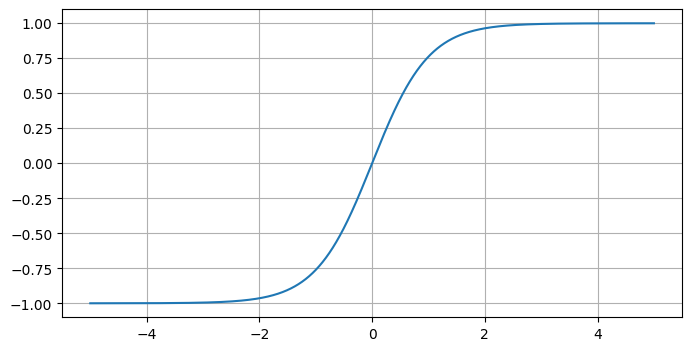

In [57]:
plot_activation_fn(np.tanh)